In [616]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import subprocess
import os

TARGET = 'MedHouseVal'
COMPETITION = 'playground-series-s3e1'

def train_val_split(input_tensors,targets, val_size=0.1, random_seed=0, true_random=False):
    """Splits the input tensors into train and validation sets. 
    Returns the train and validation sets as tensors.
    """
    num_samples = input_tensors.shape[0]
    indices = list(range(num_samples))
    split = int(np.floor(val_size * num_samples))
    if true_random:
        random_seed = np.random.randint(0, 1000)
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    train_tensors = input_tensors[train_indices]
    val_tensors = input_tensors[val_indices]
    train_targets = targets[train_indices]
    val_targets = targets[val_indices]

    print("Train Size:", train_tensors.shape)
    print("Val Size:", val_tensors.shape)

    if train_tensors.shape[0] + val_tensors.shape[0] != input_tensors.shape[0]:
        raise ValueError("Train and val sizes don't add up to input size")

    if train_tensors.shape[0] != train_targets.shape[0]:
        raise ValueError("Train tensors and targets don't match")

    return train_tensors, val_tensors, train_targets, val_targets

def load_data(target):
    # Load the data, turn it into tensors
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')

    print("Training Size:", train_df.shape)
    print("Test Size:", test_df.shape)

    FEATURES = [col for col in train_df.columns if col not in ['id', TARGET]]
    print("Num Features:", len(FEATURES))

    train_tensors = torch.tensor(train_df[FEATURES].values, dtype=torch.float32)
    target_tensors = torch.tensor(train_df[TARGET].values, dtype=torch.float32)
    test_tensors = torch.tensor(test_df[FEATURES].values, dtype=torch.float32)
    return train_tensors, target_tensors, test_tensors

def get_device(whacky_mode = False):
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available() and whacky_mode:
        return torch.device("mps")
    else:
        return torch.device("cpu")

def torch_standardize(x):
    mean = torch.mean(x, dim=0)
    std = torch.std(x, dim=0)
    return ((x - mean) / std, mean, std)

def plot_loss(**kwargs):
    """Plots the loss and accuracy of the model"""
    # Get loss and accuracy from kwargs
    loss_vals_ = kwargs.get('loss_vals', loss_vals)

    # Get epochs to plot
    total_epochs_shown = kwargs.get('epochs', 0)

    loss_vals_ = loss_vals_[-total_epochs_shown:]
    
    plt.plot(loss_vals_, label="Loss", color="green", linestyle="dashed", marker="o")
    plt.legend()
    # Add title to x axis
    plt.xlabel("Epochs")
    # Add title to y axis
    plt.ylabel("Loss")
    # Add title to graph
    plt.title("Loss vs Epochs")
    # Only show integer epochs 
    # Set y-axis to log scale
    plt.yscale("log")

    # Plot accuracy in a seperate plot 
    plt.figure()
    # Plot

# Preprocess the data
def preprocess(train_tensors, val_tensors, test_tensors, include_original=True):
    """Function for preprocessing the data before training. Currently normalizing,
    standardizing, and keeping the original values for the neural network. We 
    will pass all three concatenated to our model, and let it decide which ones
    to use.
    We will L2, L1 normalize and min/max normalize the features of x.
    For now we will focus on standardizing the data, and later we will add more
    """
    original_train_tensors = train_tensors
    original_val_tensors = val_tensors
    original_test_tensors = test_tensors

    train_tensors, train_mean, train_std = torch_standardize(train_tensors)
    val_tensors = (val_tensors - train_mean) / train_std
    test_tensors = (test_tensors - train_mean) / train_std

    if include_original:
        train_tensors = torch.cat((train_tensors, original_train_tensors), dim=1)
        val_tensors = torch.cat((val_tensors, original_val_tensors), dim=1)
        test_tensors = torch.cat((test_tensors, original_test_tensors), dim=1)
    
    return train_tensors, val_tensors, test_tensors

def submit_kaggle(**kwargs):
    """Function for submitting a file to a kaggle competition. The function
    will return the output of the kaggle cli command as a string."""

    kaggle_cli = kwargs.get("kaggle_cli",'/Users/dbless/Library/Python/3.11/bin/kaggle')
    competition = kwargs.get("competition","playground-series-s3e1")
    submission = kwargs.get("submission","submission.csv")
    message = kwargs.get("message","Statistics may be dull, but it has its moments.")

    result = subprocess.run(['./submit_kaggle.sh',kaggle_cli,competition,submission,message],cwd=os.getcwd(), capture_output=True, text=True)

    if hasattr(result, 'stderr'):
        print(result.stderr)
        
    if result.returncode == 0:
        print("Submission successful")
        
    if hasattr(result, 'stdout'):
        print(result.stdout)

    return result

class HousingDataset(Dataset):
    """Housing dataset."""

    def __init__(self, x, y=None):
        self.x = x
        self.y = y if y is not None else None

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx] if self.y is not None else torch.empty((1, 1), dtype=torch.float32)

def main_load(*args,**kwargs):
    # Get target if in kwargs
    target = kwargs.get('target', TARGET)
    train_tensors, target_tensors, test_tensors = load_data(target)

    # Get val_size, random seed and true random if in kwargs
    val_size = kwargs.get('val_size', 0.2)
    random_seed = kwargs.get('random_seed', 42)
    true_random = kwargs.get('true_random', False)
    train_tensors, val_tensors, train_targets, val_targets = train_val_split(train_tensors, target_tensors, val_size, random_seed, true_random)
    # train_tensors, val_tensors, test_tensors = preprocess(train_tensors, val_tensors, test_tensors)
    train_dataset = TensorDataset(train_tensors, train_targets)
    val_dataset = TensorDataset(val_tensors, val_targets)
    test_dataset = TensorDataset(test_tensors)

    # Data loaders
    # Get batch size if in kwargs
    batch_size = kwargs.get('batch_size', 2500)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("Train dataloader batch size", train_loader.batch_size)

    # Wrap outputs in a dictionary
    output = {
        'train_tensors': train_tensors,
        'val_tensors': val_tensors,
        'train_targets': train_targets,
        'val_targets': val_targets,
        'test_tensors': test_tensors,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        "train_loader": train_loader,
        "val_loader": val_loader,
        "test_loader": test_loader
    }
    return output


In [617]:
# Define model
class HousePricesModel(nn.Module):
    def __init__(self):
        super(HousePricesModel, self).__init__()
        self.head = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )


    def forward(self, x):
        return self.head(x)
    
def train(model, train_dl, val_dl, optimizer, loss_func, epochs, device):
    loss_vals = []
    print("-"*30)
    print(f"Training model: {model.__class__.__name__}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print()
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            y_hat = model(xb)
            y_hat = y_hat.squeeze()
            loss = loss_func(y_hat, yb)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        model.eval()
        with torch.no_grad():
            tot_loss = 0
            for xb, yb in val_dl:
                xb = xb.to(device)
                yb = yb.to(device)
                
                y_hat = model(xb)
                y_hat = y_hat.squeeze()
                loss = loss_func(y_hat, yb)
                tot_loss += loss.item() 
            val_loss = tot_loss / len(val_dl)
            print(f"Epoch: {epoch}")
            print(f"Validation loss: {val_loss}")
            print()
            loss_vals.append(val_loss)

    return loss_vals

def train_model(*args, **kwargs):
    """Function for training a model. We will use this function to train the
    model with the optimal hyperparameters found in the hyperparameter search."""

    # Get model, optimizer, loss function and dataloaders from kwargs, or use default values
    device = kwargs.get('dev', get_device())
    model = kwargs.get('model',HousePricesModel()).to(device)
    lr = kwargs.get('lr', 0.001)
    weight_decay = kwargs.get('weight_decay', 0)
    optimizer = kwargs.get('optimizer',optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay))
    loss_func = kwargs.get('loss_func', nn.MSELoss(reduction='mean'))
    train_dl = kwargs.get('train_dl',data_dict['train_loader'])
    val_dl = kwargs.get('val_dl',data_dict['val_loader'])
    epochs = kwargs.get('epochs', 100)

    # Train model
    input_model_dict = dict(model=model, optimizer=optimizer, loss_func=loss_func, train_dl=train_dl, val_dl=val_dl, epochs=epochs, device=device)

    return train(**input_model_dict),model

# Get model predictions
def make_predictions(model,**kwargs):
    device = kwargs.get('device', get_device())
    test_dl = kwargs.get('test_dl', data_dict['test_loader'])
    model.eval()
    with torch.no_grad():
        tot_loss = 0
        preds = []
        for xb in test_dl:
            xb = xb[0]
            xb = xb.to(device)
            y_hat = model(xb)
            y_hat = y_hat.squeeze()
            preds.append(y_hat)
        preds = torch.cat(preds)
        preds = preds.cpu().numpy()

    # Check preds are correct shape
    correct_num_of_preds = kwargs.get('correct_num_of_preds', data_dict['test_tensors'].shape[0])
    if preds.shape[0] != correct_num_of_preds:
        raise ValueError(f"Expected {correct_num_of_preds} predictions, but got {preds.shape[0]} predictions")
    return preds

def save_predictions(preds, **kwargs):
    # Save predictions to csv file
    filename = kwargs.get('filename', 'submission.csv')
    target = kwargs.get('target', TARGET)
    # Copy Ids from sample submission
    df = pd.read_csv('sample_submission.csv')
    df[target] = preds

    # Make sure we have two columns in df
    assert df.shape[1] == 2, f"Expected df to have 2 columns, but got {df.shape[1]} columns"
    df.to_csv(filename, index=False)
    return

def make_and_save_predictions(model, **kwargs):
    preds = make_predictions(model, **kwargs)
    save_predictions(preds, **kwargs)

    return preds

def main_submit(model,**kwargs):
    make_and_save_predictions(model,**kwargs)
    submit_kaggle(**kwargs)
    return

# Train model
data_dict = main_load()
loss_vals,model = train_model()

Training Size: (37137, 10)
Test Size: (24759, 9)
Num Features: 8
Train Size: torch.Size([29710, 8])
Val Size: torch.Size([7427, 8])
Train dataloader batch size 2500
------------------------------
Training model: HousePricesModel
Optimizer: Adam

Epoch: 0
Validation loss: 29.491183598836262

Epoch: 1
Validation loss: 28.603092193603516

Epoch: 2
Validation loss: 2.5633246898651123

Epoch: 3
Validation loss: 3.323400100072225

Epoch: 4
Validation loss: 2.2856554985046387

Epoch: 5
Validation loss: 1.9127310514450073

Epoch: 6
Validation loss: 1.6645317475001018

Epoch: 7
Validation loss: 1.4353830019632976

Epoch: 8
Validation loss: 1.3836218516031902

Epoch: 9
Validation loss: 1.3600092728932698

Epoch: 10
Validation loss: 1.347630540529887

Epoch: 11
Validation loss: 1.3271684646606445

Epoch: 12
Validation loss: 1.292392333348592

Epoch: 13
Validation loss: 1.277342160542806

Epoch: 14
Validation loss: 1.2300628026326497

Epoch: 15
Validation loss: 1.2139103809992473

Epoch: 16
Valida

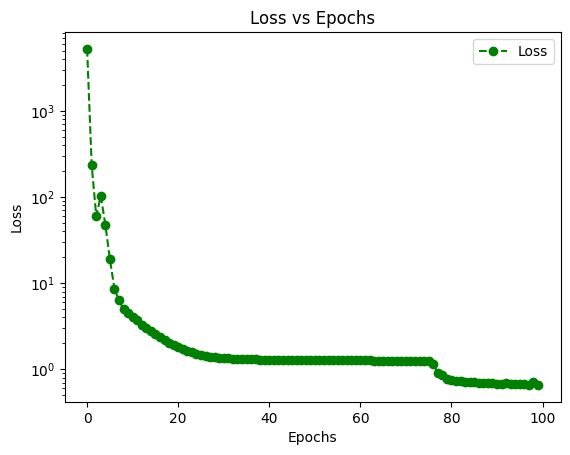

<Figure size 640x480 with 0 Axes>

In [514]:
plot_loss()